# MOVIE RECOMMENDATION SYSTEM

**IMPORTING LIBRARIES**

In [21]:
!killall ngrok

ngrok: no process found


In [22]:
!pip install pyngrok

In [23]:
!ngrok authtoken 2jPXukRBu0ToT3Rp8oGb5ghYb5Q_7zZyY2hk3XF9cavB4RvhQ

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Dropout, Concatenate, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

In [41]:
ratings = pd.read_csv('/content/ratings.csv')
ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [42]:
movies = pd.read_csv('/content/movies.csv')
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [43]:
#Preprocessing the data
# Merge ratings and movies datasets
data = pd.merge(ratings, movies, on='movieId')

# Encode userId and movieId
user_ids = data['userId'].unique().tolist()
movie_ids = data['movieId'].unique().tolist()

user_to_index = {x: i for i, x in enumerate(user_ids)}
movie_to_index = {x: i for i, x in enumerate(movie_ids)}

data['user'] = data['userId'].map(user_to_index)
data['movie'] = data['movieId'].map(movie_to_index)

In [44]:
data

,userId,movieId,rating,timestamp,title,genres,user,movie
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,0
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2,0
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3,0
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4,0
...,...,...,...,...,...,...,...,...
100831,610,160341,2.5,1479545749,Bloodmoon (1997),Action|Thriller,214,9719
100832,610,160527,4.5,1479544998,Sympathy for the Underdog (1971),Action|Crime|Drama,214,9720
100833,610,160836,3.0,1493844794,Hazard (2005),Action|Drama|Thriller,214,9721
100834,610,163937,3.5,1493848789,Blair Witch (2016),Horror|Thriller,214,9722


<Axes: xlabel='rating', ylabel='Count'>

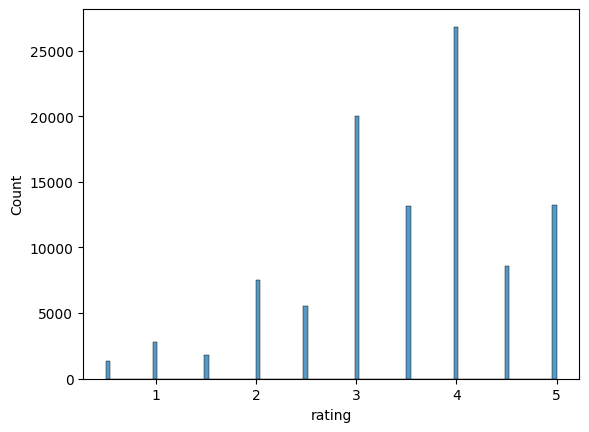

In [28]:
sns.histplot(ratings['rating'])

In [29]:
from keras.callbacks import EarlyStopping
# Split the data
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Define model parameters
n_users = len(user_ids)
n_movies = len(movie_ids)
embedding_size = 50  # Adjust this value as needed

# User embedding input and layer
user_input = Input(shape=(1,), name='user_input')
user_embedding = Embedding(input_dim=n_users, output_dim=embedding_size, embeddings_regularizer=l2(1e-5), name='user_embedding')(user_input)
user_flatten = Flatten()(user_embedding)

# Movie embedding input and layer
movie_input = Input(shape=(1,), name='movie_input')
movie_embedding = Embedding(input_dim=n_movies, output_dim=embedding_size, embeddings_regularizer=l2(1e-5), name='movie_embedding')(movie_input)
movie_flatten = Flatten()(movie_embedding)

# Concatenate user and movie embeddings
concatenated = Concatenate()([user_flatten, movie_flatten])
x = Dense(128, activation='relu')(concatenated)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(1)(x)

# Build and compile the model
model = Model(inputs=[user_input, movie_input], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Prepare training and testing data
X_train = [train_data['user'].values, train_data['movie'].values]
y_train = train_data['rating'].values
X_test = [test_data['user'].values, test_data['movie'].values]
y_test = test_data['rating'].values


early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train,
                    epochs=30,
                    batch_size=64,
                    validation_split=0.2,
                    callbacks=[early_stopping],
                    verbose=1)
# Save the model
model.save('movie_recommender_model.keras')

# Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

Epoch 1/30
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 24s 20ms/step - loss: 7.3881 - val_loss: 1.0874
Epoch 2/30
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 1.4340 - val_loss: 0.8745
Epoch 3/30
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 1.0637 - val_loss: 0.8289
Epoch 4/30
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 0.8866 - val_loss: 0.7731
Epoch 5/30
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.8167 - val_loss: 0.7632
Epoch 6/30
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 0.7714 - val_loss: 0.7621
Epoch 7/30
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.7319 - val_loss: 0.7648
Epoch 8/30
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.7007 - val_loss: 0.7712
Epoch 9/30
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step - loss: 0.6593 - val_loss: 0.7838
Epoch 10/30
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - loss: 0.6286 - val_loss: 0.7979
Epoch 11/30
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.5867 - val_loss: 0.8008
Epoch 12/30
1

In [30]:
pip install streamlit

In [31]:
pip install pymongo

In [45]:
%%writefile app.py
import streamlit as st
import numpy as np
from tensorflow.keras.models import load_model
from pymongo import MongoClient

# Load the trained model
model = load_model('movie_recommender_model.keras')

# Function to get movie details by movie ID
def get_movie_by_id(movie_id):
    db = MongoClient('mongodb://localhost:27017/')['movie_db']
    movie_collection = db['movies']
    movie = movie_collection.find_one({'movieId': movie_id})
    return movie

# Function to get movie ID from the movie name
def get_movie_id_from_name(movie_name):
    db = MongoClient('mongodb://localhost:27017/')['movie_db']
    movie_collection = db['movies']
    movie = movie_collection.find_one({'title': movie_name})
    if movie:
        return movie['movieId']
    else:
        return None

# Streamlit interface
st.title("Movie Recommender System")

# Input fields for user ID, movie name, and movie ID
user_id = st.text_input("Enter User ID:")
movie_name = st.text_input("Enter Movie Name:")
movie_id = st.text_input("Or Enter Movie ID:")

# Button to make the prediction
if st.button("Predict Rating"):
    if user_id:
        if movie_id:
            movie = get_movie_by_id(int(movie_id))
        elif movie_name:
            movie_id = get_movie_id_from_name(movie_name)
            movie = get_movie_by_id(movie_id)
        else:
            st.error('Please provide either a Movie Name or a Movie ID.')
            movie = None

        if movie is None:
            st.error('Movie not found')
        else:
            # Prepare the input data
            user_input = np.array([int(user_id)]).reshape(1, 1)
            movie_input = np.array([movie['movieId']]).reshape(1, 1)

            # Make prediction
            prediction = model.predict([user_input, movie_input])
            rating = prediction[0][0]

            st.success(f"Predicted Rating for '{movie['title']}': {rating}")
    else:
        st.error('Please provide User ID.')


Overwriting app.py


In [46]:
MongoClient('mongodb://localhost:27017/')


MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True)

In [47]:
from pyngrok import ngrok
public_url = ngrok.connect(8501, bind_tls=True)
print(f"Link: {public_url}")
!streamlit run app.py &>/dev/null&

Link: NgrokTunnel: "https://8b36-35-227-77-126.ngrok-free.app" -> "http://localhost:8501"
